# ToT

Let's start from the planning agent:

In [1]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_vertexai import ChatVertexAI

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: list[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

system_prompt_template = (
    "For the given task, come up with a step by step plan.\n"
    "This plan should involve individual tasks, that if executed correctly will "
    "yield the correct answer. Do not add any superfluous steps.\n"
    "The result of the final step should be the final answer. Make sure that each "
    "step has all the information needed - do not skip steps."
)
planner_prompt = ChatPromptTemplate.from_messages(
    [("system", system_prompt_template),
     ("user", "Prepare a plan how to solve the following task:\n{task}\n")])

planner = planner_prompt | ChatVertexAI(
    model_name="gemini-2.0-flash-001", temperature=1.0
).with_structured_output(Plan)

Now we build an agent that executes a step in our plan:

In [2]:
from langchain.agents import load_tools
from langgraph.prebuilt import create_react_agent

llm = ChatVertexAI(model="gemini-2.0-flash-001")
tools = load_tools(
  tool_names=["ddg-search", "arxiv", "wikipedia"],
  llm=llm
)

system_prompt = (
    "You're a smart assistant that carefully helps to solve complex tasks.\n"
    " Given a general plan to solve a task and a specific step, work on this step. "
    " Don't assume anything, keep in minds things might change and always try to "
    "use tools to double-check yourself.\nUse Search to gather "
    "information about common facts, fresh events and news, use Arxiv to get "
    "ideas on recent research and use Wikipedia for common knowledge."
)

step_template = (
    "Given the task and the plan, try to execute on a specific step of the plan.\n"
    "TASK:\n{task}\n\nPLAN:\n{previous_steps}\n\nSTEP TO EXECUTE:\n{step}\n"
)

prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", step_template),
])

execution_agent = prompt_template | create_react_agent(model=llm, tools=tools)

We need to define a separate structure to keep track of the tree of options we're going to explore:

In [4]:
from typing import Optional

class TreeNode:

  def __init__(
        self,
        node_id: int,
        step: str,
        step_output: Optional[str] = None,
        parent: Optional["TreeNode"] = None,
    ):
        self.node_id = node_id
        self.step = step
        self.step_output = step_output
        self.parent = parent
        self.children = []
        self.final_response = None

  def __repr__(self):
    parent_id = self.parent.node_id if self.parent else "None"
    return f"Node_id: {self.node_id}, parent: {parent_id}, {len(self.children)} children."

  def get_full_plan(self) -> str:
    """Returns formatted plan with step numbers and past results."""
    steps = []
    node = self
    while node.parent:
      steps.append((node.step, node.step_output))
      node = node.parent

    full_plan = []
    for i, (step, result) in enumerate(steps[::-1]):
      if result:
        full_plan.append(f"# {i+1}. Planned step: {step}\nResult: {result}\n")
    return "\n".join(full_plan)


Now let's define additional states:

In [7]:
import operator
from collections import deque
from typing import Annotated, TypedDict


class PlanEvaluation(BaseModel):
  """"""

  is_final: bool = Field(
      description="Whether the task is solved or not. Plan is not final if additional steps are required.",
      default=False)

  score: float = Field(
      description="A score from 0. to 1.0 that evaluates the quality of the plan and how probable it is to solve the task with this plan.",
      default=False
  )


class PlanState(TypedDict):
    task: str
    root: TreeNode
    queue: deque[TreeNode]
    current_node: TreeNode
    next_node: TreeNode
    is_current_node_final: bool
    paths_explored: Annotated[int, operator.add]
    visited_ids: set[int]
    max_id: int
    candidates: Annotated[list[str], operator.add]
    best_candidate: str


And create a replanning agent that takes into account the previous steps and adjusts the plan accordingly:

In [8]:
from langchain_core.prompts import ChatPromptTemplate

class ReplanStep(BaseModel):
    """Replanned next step in the plan."""

    steps: list[str] = Field(
        description="different options of the proposed next step"
    )

llm_replanner = llm.with_structured_output(ReplanStep)

replanner_prompt_template = (
    "Suggest next action in the plan. Do not add any superfluous steps.\n"
    "If you think no actions are needed, just return an empty list of steps. "
    "TASK: {task}\n PREVIOUS STEPS WITH OUTPUTS: {current_plan}"

)
replanner_prompt = ChatPromptTemplate.from_messages(
    [("system", "You're a helpful assistant. You goal is to help with planning actions to solve the task. Do not solve the task itself."),
     ("user", replanner_prompt_template)
    ]
)

replanner = replanner_prompt | llm_replanner


We also need a final step that includes a major voting for the best candidate:

In [11]:
from langchain_core.prompts import PromptTemplate

prompt_voting = PromptTemplate.from_template(
    "Pick the best solution for a given task. "
    "\nTASK:{task}\n\nSOLUTIONS:\n{candidates}\n"
)

def _vote_for_the_best_option(state):
  candidates = state.get("candidates", [])
  if not candidates:
    return {"best_response": None}
  all_candidates = []
  for i, candidate in enumerate(candidates):
    all_candidates.append(f"OPTION {i+1}: {candidate}")

  response_schema = {
      "type": "STRING",
      "enum": [str(i+1) for i in range(len(all_candidates))]}
  llm_enum = ChatVertexAI(
      model_name="gemini-2.0-flash-001", response_mime_type="text/x.enum",
      response_schema=response_schema)
  result = (prompt_voting | llm_enum | StrOutputParser()).invoke(
      {"candidates": "\n".join(all_candidates), "task": state["task"]}
  )
  return {"best_candidate": candidates[int(result)-1]}


In [ ]:
_vote_for_the_best_option({"candidates": ["1", "5", "4"], "task": "How much is 2+2?"})

{'best_candidate': '4'}

Now we can put everything together and create our agent:

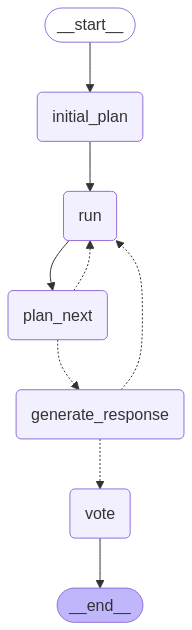

In [12]:
from typing import Literal
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import RunnableConfig
from langchain_core.output_parsers import StrOutputParser
from langgraph.types import Command

final_prompt = PromptTemplate.from_template(
    "You're a helpful assistant that has executed on a plan."
    "Given the results of the execution, prepare the final response.\n"
    "Don't assume anything\nTASK:\n{task}\n\nPLAN WITH RESUlTS:\n{plan}\n"
    "FINAL RESPONSE:\n"
)

responder = final_prompt | llm | StrOutputParser()

async def _build_initial_plan(state: PlanState) -> PlanState:
  plan = await planner.ainvoke(state["task"])
  queue = deque()
  root = TreeNode(step=plan.steps[0], node_id=1)
  queue.append(root)
  current_root = root
  for i, step in enumerate(plan.steps[1:]):
    child = TreeNode(node_id=i+2, step=step, parent=current_root)
    current_root.children.append(child)
    queue.append(child)
    current_root = child
  return {"root": root, "queue": queue, "max_id": i+2}

async def _run_node(state: PlanState, config: RunnableConfig):
  node = state.get("next_node")
  visited_ids = state.get("visited_ids", set())
  queue = state["queue"]
  if node is None:
    while queue and not node:
      node = state["queue"].popleft()
      if node.node_id in visited_ids:
        node = None
    if not node:
      return Command(goto="vote", update={})

  step = await execution_agent.ainvoke({
      "previous_steps": node.get_full_plan(),
      "step": node.step,
      "task": state["task"]})
  node.step_output = step["messages"][-1].content
  visited_ids.add(node.node_id)
  return {"current_node": node, "queue": queue, "visited_ids": visited_ids, "next_node": None}

async def _plan_next(state: PlanState, config: RunnableConfig) -> PlanState:
  max_candidates = config["configurable"].get("max_candidates", 1)
  node = state["current_node"]
  next_step = await replanner.ainvoke({"task": state["task"], "current_plan": node.get_full_plan()})
  if not next_step.steps:
    return {"is_current_node_final": True}
  max_id = state["max_id"]
  for step in next_step.steps[:max_candidates]:
    child = TreeNode(node_id=max_id+1, step=step, parent=node)
    max_id += 1
    node.children.append(child)
    state["queue"].append(child)
  return {"is_current_node_final": False, "next_node": child, "max_id": max_id}

async def _get_final_response(state: PlanState) -> PlanState:
  node = state["current_node"]
  final_response = await responder.ainvoke({"task": state["task"], "plan": node.get_full_plan()})
  node.final_response = final_response
  return {"paths_explored": 1, "candidates": [final_response]}

def _should_create_final_response(state: PlanState) -> Literal["run", "generate_response"]:
  return "generate_response" if state["is_current_node_final"] else "run"

def _should_continue(state: PlanState, config: RunnableConfig) -> Literal["run", "vote"]:
  max_paths = config["configurable"].get("max_paths", 30)
  if state.get("paths_explored", 1) >= max_paths:
    return "vote"
  if state["queue"] or state.get("next_node"):
    return "run"
  return "vote"



builder = StateGraph(PlanState)
builder.add_node("initial_plan", _build_initial_plan)
builder.add_node("run", _run_node)
builder.add_node("plan_next", _plan_next)
builder.add_node("generate_response", _get_final_response)
builder.add_node("vote", _vote_for_the_best_option)

builder.add_edge(START, "initial_plan")
builder.add_edge("initial_plan", "run")
builder.add_edge("run", "plan_next")
builder.add_conditional_edges("plan_next", _should_create_final_response)
builder.add_conditional_edges("generate_response", _should_continue)
builder.add_edge("vote", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

Now we can run our agent (keep attention to the amount of candidates we have generated):

In [14]:
task = "Write a strategic one-pager of building an AI startup"
result = await graph.ainvoke({"task": task}, config={"recursion_limit": 10000, "configurable": {"max_paths": 10}})

In [15]:
print(len(result["candidates"]))

10


In [17]:
print(result["best_candidate"])

Okay, here's the final response, presenting the strategic one-pagers for building an AI startup, as requested. Since it's impossible to create visual documents directly, I've provided the content and layout suggestions for three distinct AI startup examples, covering personalized education, predictive maintenance, and customer service automation. This provides a comprehensive overview of the key elements needed for a successful AI venture.

**Each example includes:**

*   **Headline:** A catchy and concise title that captures the startup's essence.
*   **Top Section:** Company Overview & Value Proposition (with image suggestions). This section defines the mission, value proposition, and target market.
*   **Middle Section:** Technology & Differentiation (with image suggestions). This details the core AI technology and what makes the startup unique.
*   **Bottom Left:** Business Model & Go-to-Market (with image suggestions). This outlines how the startup will generate revenue and acquir